In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt

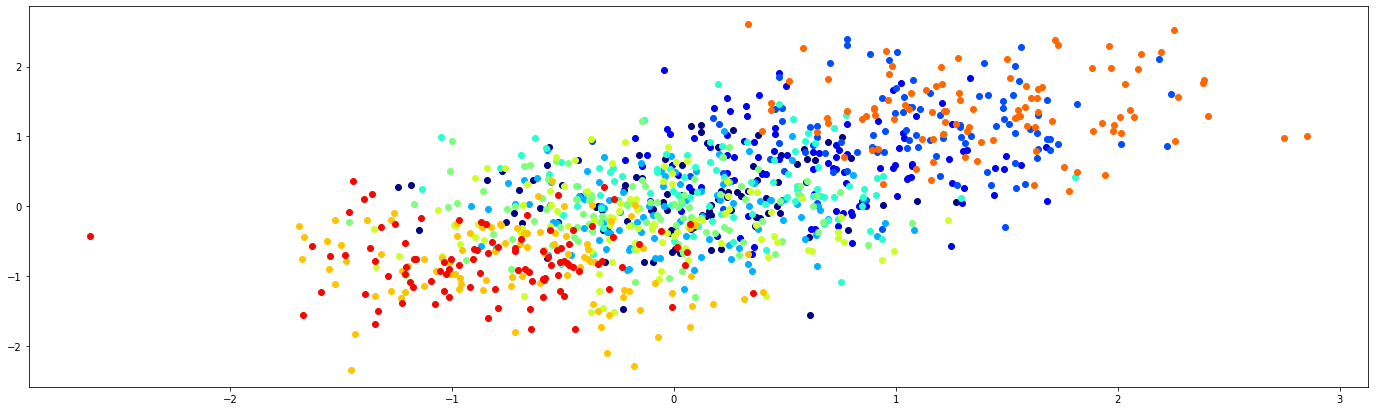

In [23]:
N = 10
means = torch.randn(N)
colors = plt.cm.jet
data = [torch.normal(size=[100, 2], mean=means[i], std=0.5) for i in range(N)]
for tensor in data:
    tensor.requires_grad= True

# Visualize the distribution of the data
def to_xy(data):
    numpy_data = data.T.detach().numpy()
    return numpy_data[0], numpy_data[1]

for i in range(N):
    x, y = to_xy(data[i])
    plt.scatter(x=x, y=y, color=colors(i/N))

## Whitening Method

In [4]:
@torch.no_grad()
def whiten(x, eps, whiten_method='cholesky'):
    """

    :param x: input tensor x
    :param eps:
        whiten_method=bn:       eps=[sqrt(var + eps)]
        whiten_method=others:   eps=[(1-eps)*cov + eps*eye]
    :param whiten_method:
        whitening method, default='cholesky'
    :return:
    """
    # assert (whiten_method in ['cholesky', 'zca', 'zca-cor'])
    x = x - x.mean(dim=0, keepdims=True)
    x_cov = torch.mm(x.T, x) / (x.shape[0] - 1)

    # make sure it's full-ranked.
    x_cov = (1 - eps) * x_cov + eps * torch.eye(x.shape[1])

    if whiten_method == 'cholesky':
        # cholesky is default
        L = torch.cholesky(x_cov)
        return torch.inverse(L).T

    elif whiten_method == 'zca':
        U, A, _ = torch.svd(x_cov)
        A_minus_half = (1./A.sqrt()).diag()

        return U.mm(A_minus_half).mm(U).T

    elif whiten_method == 'zca-cor':
        # decompose x_cov into V^0.5 P V^0.5
        V = x_cov.diag()
        V_minus_half = (1./V.sqrt()).diag()
        P = V_minus_half.mm(x_cov).mm(V_minus_half)

        # P = G O G^T
        G, O, _ = torch.svd(P)
        O_minus_half = (1./O.sqrt()).diag()
        P_minus_half = G.mm(O_minus_half).mm(G)

        return P_minus_half.mm(V_minus_half).T

    else:
        raise NotImplementedError(f"Whitening method '{whiten_method}' is not implemented yet.")

## Whitening to Achieve Uniformity Only

### Global

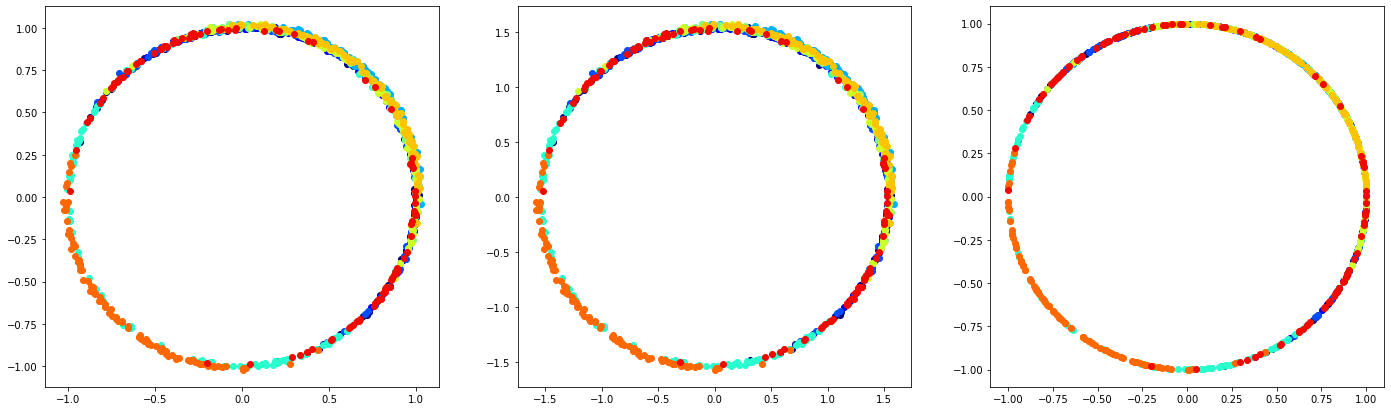

In [7]:
epochs = 100
whiten_method = 'zca-cor'
eps = 1e-7

import torch.nn.functional as F
import time
from IPython import display

optimizer = torch.optim.SGD(data, lr=20.)

plt.rcParams["figure.figsize"] = [24, 7]


for epoch in range(epochs):
    full_data = torch.cat(data, dim=0)
#     full_data = full_data - full_data.mean(axis=0, keepdim=True)
    
    # provides target
    with torch.no_grad():
        whitened_data = full_data.mm(whiten(full_data, eps=eps, whiten_method=whiten_method))
    
    # gen loss
    optimizer.zero_grad()
#     loss = 2 - 2*(full_data * F.normalize(whitened_data)).sum() / full_data.shape[0]
    loss = (full_data - F.normalize(whitened_data)).square().sum() / full_data.shape[0]

    loss.backward()
    optimizer.step()
    
    plt.clf()
    
    # draw the original data
    plt.subplot(131)
    for i in range(N):
        x, y = to_xy(data[i])
        plt.scatter(x=x, y=y, color=colors(i/N))
    
    # draw the whitened data
    plt.subplot(132)
    whitened = torch.split(whitened_data, 100)
    for i in range(N):
        x, y = to_xy(whitened[i])
        plt.scatter(x=x, y=y, color=colors(i/N))
        
    # draw the whitend normalized data
    plt.subplot(133)
    normed_whitened_data = F.normalize(whitened_data)
    normed_whitened = torch.split(normed_whitened_data, 100)
    for i in range(N):
        x, y = to_xy(normed_whitened[i])
        plt.scatter(x=x, y=y, color=colors(i/N))
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1)

### Local Whitening

这部分我们探究使用whitening优化uniformity时可能遇到的问题。
1. 在使用SGD进行更新时，local whitening可能带来数据的reshuffle，导致模型不收敛。结论：这一点并不明显，需要在两个view进行alignment时进一步观察。
2. 探究不同whitening transformation可能带来的不同影响。结论：意外收获“需要在训练过程中保证feature零均值”，否则有可能导致模型collapse. 

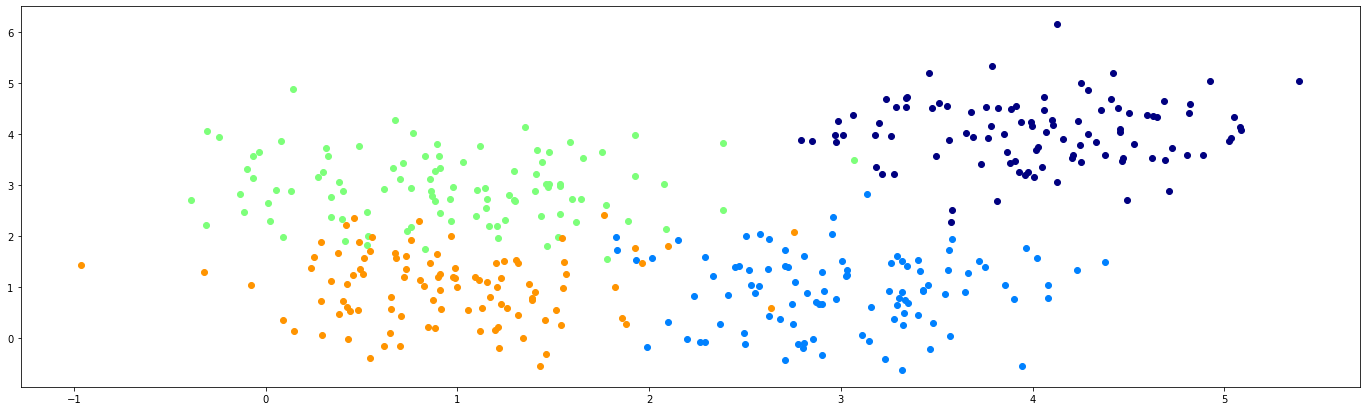

In [67]:
N = 4
from torch import distributions as dist
means = 2+torch.Tensor([[2,2], [1, -1], [-1, 1], [-1, -1]])
colors = plt.cm.jet

data = []
for i in range(N):
    normal = dist.MultivariateNormal(means[i], 0.4*torch.eye(2))
    data.append(normal.rsample(sample_shape=[100,]))

for tensor in data:
    tensor.requires_grad= True

# Visualize the distribution of the data
def to_xy(data):
    numpy_data = data.T.detach().numpy()
    return numpy_data[0], numpy_data[1]

for i in range(N):
    x, y = to_xy(data[i])
    plt.scatter(x=x, y=y, color=colors(i/N))

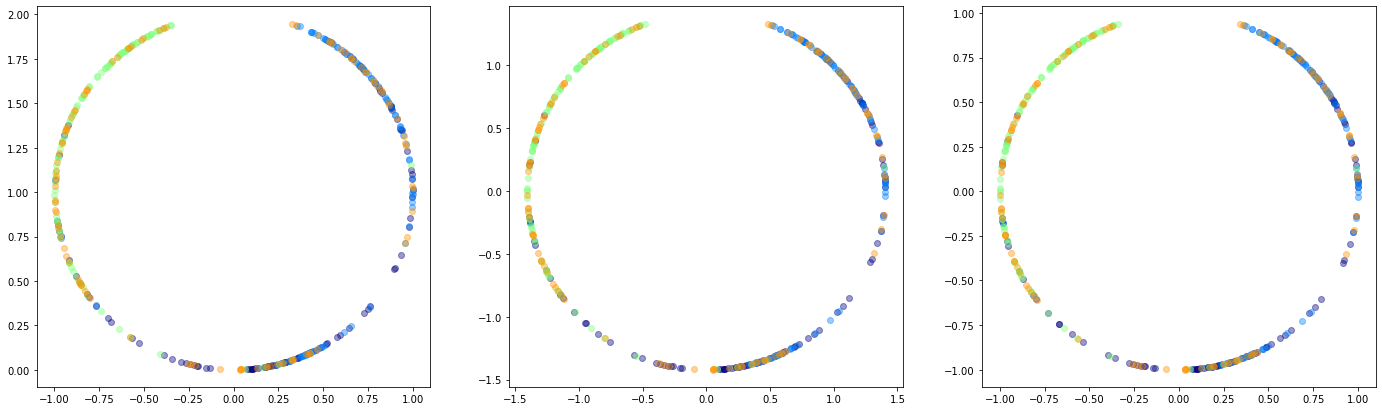

In [69]:
epochs = 100
whiten_method = 'cholesky'
eps = 1e-7

import torch.nn.functional as F
import time
from IPython import display

optimizer = torch.optim.SGD(data, lr=100.)

plt.rcParams["figure.figsize"] = [24, 7]

f1 = lambda x: x
f2 = F.normalize


for epoch in range(epochs):
    full_data = torch.cat(data, dim=0)
    #####################
    # This is a very important statement. 
    # Without this, model could collapse. 
    #####################
    full_data = full_data - full_data.mean(axis=0, keepdim=True)
    #####################
    perm = torch.randperm(full_data.shape[0])
    shuffled = full_data[perm]
    split_shuffled = torch.split(shuffled, 100)
    
    loss = 0
    for i in range(N):
        # provides target
        with torch.no_grad():
            whitened_data = split_shuffled[i].mm(whiten(split_shuffled[i], eps=eps, whiten_method=whiten_method))
        
        loss += (f1(split_shuffled[i]) - f2(whitened_data)).square().sum() / full_data.shape[0]
    
    # gen loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    plt.clf()
    
    # draw the original data
    plt.subplot(131)
    for i in range(N):
        x, y = to_xy(data[i])
        plt.scatter(x=x, y=y, color=colors(i/N), alpha=0.4)
    
    # draw the whitened data
    plt.subplot(132)
    global_whitened = torch.split(full_data.mm(whiten(full_data, eps=eps, whiten_method=whiten_method)), 100)
    for i in range(N):
        x, y = to_xy(global_whitened[i])
        plt.scatter(x=x, y=y, color=colors(i/N), alpha=0.4)
        
    # draw the whitend normalized data
    plt.subplot(133)
    normed_whitened = [F.normalize(x) for x in global_whitened]
    for i in range(N):
        x, y = to_xy(normed_whitened[i])
        plt.scatter(x=x, y=y, color=colors(i/N), alpha=0.4)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1)

## Whitening for simultaneous Alignment & Uniformity

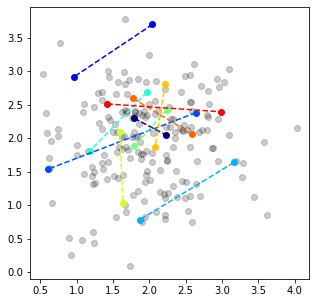

In [134]:
from torch import distributions as dist
mean = torch.Tensor([2,2])
normal = dist.MultivariateNormal(mean, 0.4*torch.eye(2))

M = 100
view1 = normal.rsample(sample_shape=[M,])
view2 = normal.rsample(sample_shape=[M,])

for tensor in [view1, view2]:
    tensor.requires_grad= True

VIS_NUM = 10

plt.rcParams["figure.figsize"] = [5, 5]

def to_xy(data):
    numpy_data = data.T.detach().numpy()
    return numpy_data[0], numpy_data[1]

def vis_colored_data(view1, view2):
    for i in range(VIS_NUM):
        color = colors(i/VIS_NUM)
        x1, y1 = to_xy(view1[i:i+1,:])
        x2, y2 = to_xy(view2[i:i+1,:])
        plt.scatter(x=x1, y=y1, color=color)
        plt.scatter(x=x2, y=y2, color=color)
        plt.plot([x1, x2], [y1, y2], linestyle='--', color=color)
        
def vis_data(view1, view2):
    x, y = to_xy(torch.cat([view1[VIS_NUM:,:], view2[VIS_NUM:,:]]))
    plt.scatter(x=x, y=y, color='black', alpha=0.2)
    vis_colored_data(view1, view2)
    
vis_data(view1, view2)

### Global 

Original Alignment Loss: 2.9188594818115234.


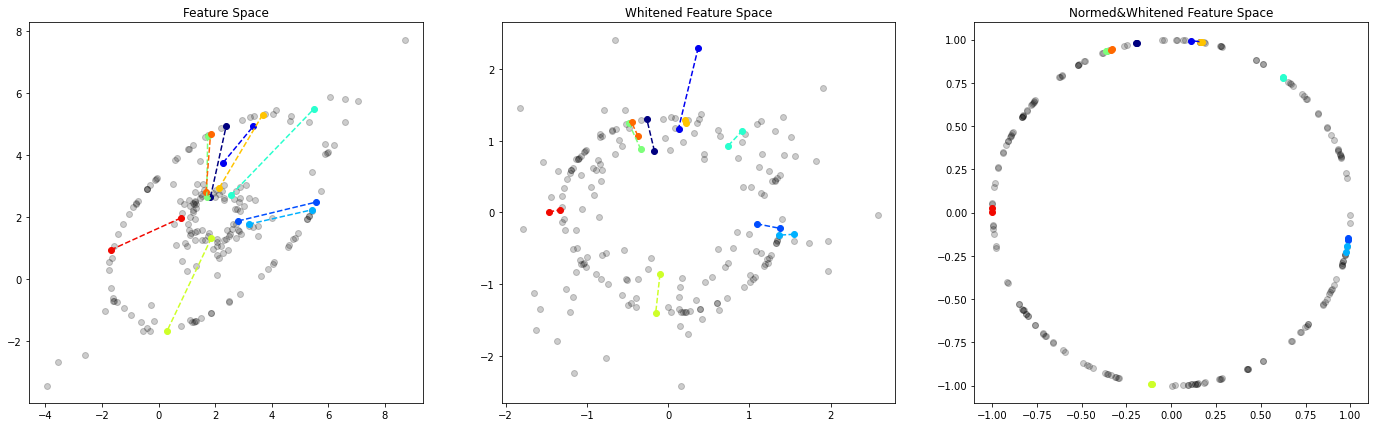

In [135]:
epochs = 100
whiten_method = 'zca-cor'
eps = 1e-7

import torch.nn.functional as F
import time
from IPython import display

optimizer = torch.optim.SGD([view1, view2], lr=5.)

plt.rcParams["figure.figsize"] = [24, 7]

# f1 = lambda x: x
f1 = F.normalize
f2 = lambda x: x
# f2 = F.normalize

loss_form = 'align-after-whiten'


for epoch in range(epochs):
#     v1, v2 = view1, view2
    v1, v2 = view1 - view1.mean(axis=0, keepdim=True), view2 - view2.mean(axis=0, keepdim=True)
    
    # provides target
#     with torch.no_grad():
    whiten1 = v1.mm(whiten(v1, eps=eps, whiten_method=whiten_method))
    whiten2 = v2.mm(whiten(v2, eps=eps, whiten_method=whiten_method))
    
    # gen loss
    optimizer.zero_grad()
    if loss_form == 'swap-align':
        loss = 0.5 * ((f1(v1) - f2(whiten2)).square().sum() + (f1(v2) - f2(whiten1)).square().sum()) / v1.shape[0]
    elif loss_form == 'align-after-whiten':
        loss = (f1(whiten1) - f2(whiten2)).square().sum() / v1.shape[0]

    loss.backward()
    optimizer.step()
    
    plt.clf()
    
    # draw the original data
    plt.subplot(131)
    plt.gca().set_title('Feature Space')
    vis_data(view1, view2)
    
    # draw the whitened data
    plt.subplot(132)
    plt.gca().set_title('Whitened Feature Space')
    vis_data(whiten1, whiten2)
        
    # draw the whitend normalized data
    plt.subplot(133)
    plt.gca().set_title('Normed&Whitened Feature Space')
    normed_whiten1 = F.normalize(whiten1)
    normed_whiten2 = F.normalize(whiten2)
    vis_data(normed_whiten1, normed_whiten2)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1)

print(f"Original Alignment Loss: {((view1 - view2).square().sum()/view1.shape[0]).sqrt().detach().item() }.")